# Homework 4 Problems

Please ensure to provide text responses to the predefined markdown cells using concise responses. 

In [1]:
import numpy as np
import pyDOE as doe
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings("ignore")

# Problem 1

A "simulation" that captures the amount of product $f(x_1,x_2)$ of a reactor as a function of inlet molar concetration ($x_1$) and pressure ($x_2$) is represented by the function below: 

$ f(x_1,x_2 )= 100(x_2-x_1^2)^2 + (1-x_1)^2 $ 

Within the bounded region: $0≤x_1≤1$ and $0.5≤x_2≤3$.

## A) Write a Python definition of this function that would take as an input $x$ and returns the value of the f. 

In [2]:
# Create definition here:
def blackbox_function(x1,x2):
    return 100*(x2 - x1**2)**2 + (1 - x1)**2

## B) Create a 3D plot of the response surface

Plot the surface and observe, is it convex or noncovex?

the function is convex


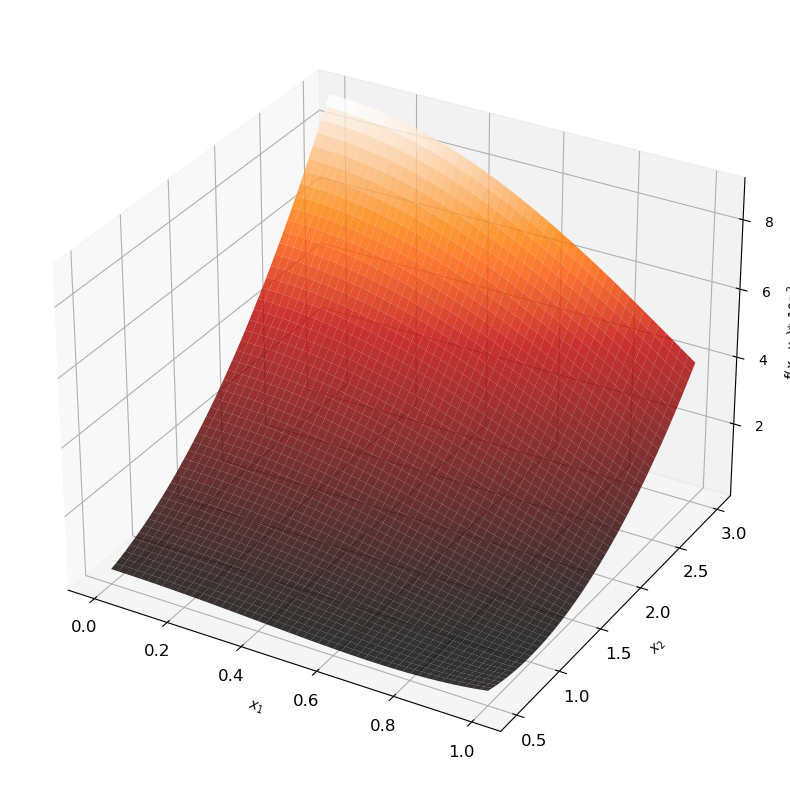

In [3]:
nsamples = 1000
x1 = np.linspace(0,1,nsamples)
x2 = np.linspace(0.5,3,nsamples)

#------------------------------------------------------------------------------------------------------------------
#plotting (x1,x2) vs f(x1,x2)
X1,X2 = np.meshgrid(x1,x2)
F = blackbox_function(X1,X2)/100
fig = plt.figure(figsize = [10,10])
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, F, cmap='gist_heat',alpha=0.8, edgecolor='none')
ax.set(xlabel = '$x_1$', ylabel ='$x_2$', zlabel = 'f($x_1$,$x_2$)* $10^{-2}$') 
ax.xaxis.set_tick_params(labelsize=12), ax.yaxis.set_tick_params(labelsize=12)
print('the function is convex')

## C) Sampling assuming above is a "black-box". 

Assume that this is an "expensive" simulation to run and you do not have access to the equation relating $f$ to $(x_1, x_2) $. 

Each run to the simulation takes about 15 minutes and you only have up to ~10 hours of computation available to you for data collection, and no parallel computing resources. You need to collect some data from this simulation to do some further analysis about the problem (i.e., fit regression models, validate the models, and then subsequently do optimization). 

Write code to design your experiments and collect your data below.


In [4]:
# Sampling code:

#alternative: pyDOE can be used!

def lhs_sampling(dimension,num_samples,criterion = 'random'):
    
    #this generates LHS between 0,1. Real data to be scaled accordingly
    lbs = np.arange(0, num_samples)/num_samples
    ubs = np.arange(1, 1+num_samples)/num_samples
    if criterion == 'random':
        generatedPoints = np.random.uniform(lbs,ubs,[dimension,num_samples])
    elif criterion == 'centered':
        generatedPoints = np.random.uniform(lbs+1/2/num_samples,ubs-1/2/num_samples,[dimension,num_samples])
    
    for i in range(1,dim):
        #since all variables x1,x2,x3.. are generated in the same order (0,1) ascending, shuffle them
        np.random.shuffle(generatedPoints[i,:])
    return np.transpose(generatedPoints)

## D) Create a 2D plot to show the collected data point locations. 

Comment on how you selected your design and total number of points here: 


Text(0.5, 1.0, 'LHS - centered')

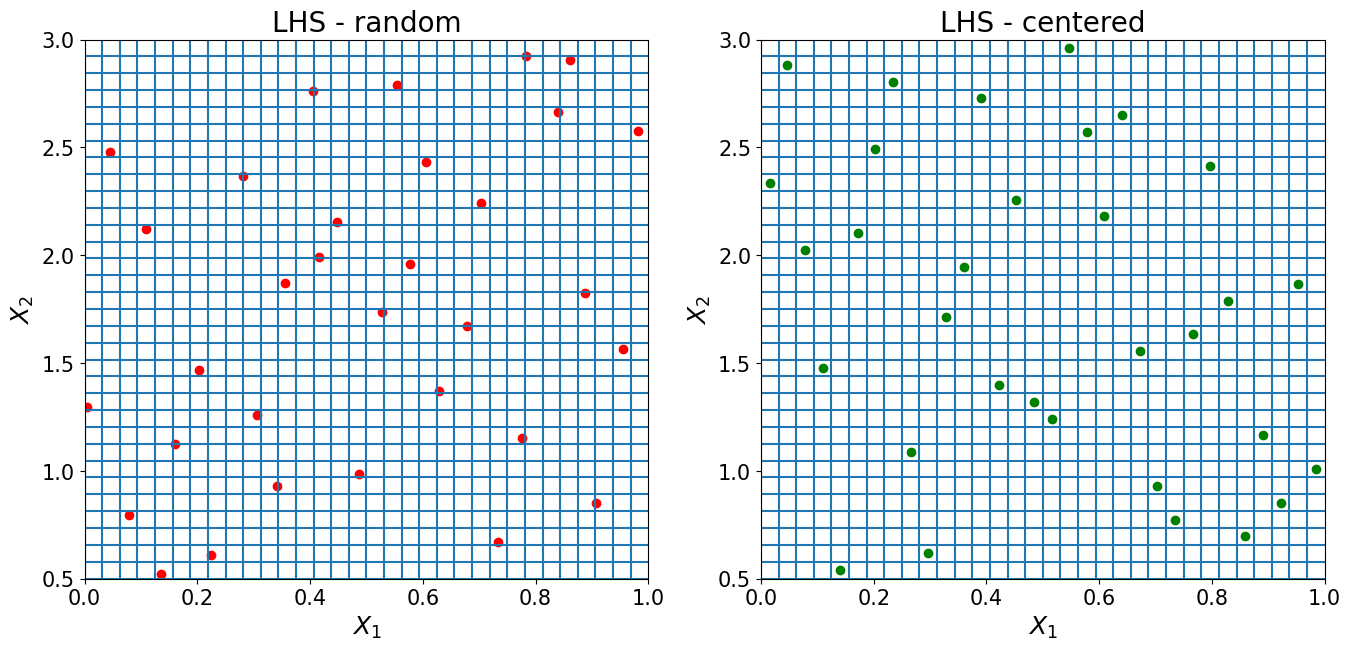

In [5]:
# Plotting design of experiments here:
nsamples =  32  
dim = 2

bounds1 = [0,1]
bounds2 = [0.5,3]
#-------------------------------------------------------------------------------------
samples = lhs_sampling(dim, nsamples, criterion = 'random')

#rescale your samples
samples[:,0] = samples[:,0]*(bounds1[1] - bounds1[0]) + bounds1[0]
samples[:,1] = samples[:,1]*(bounds2[1] - bounds2[0]) + bounds2[0]

#plot the generated data, LHS design
fig, ax = plt.subplots(1,2, figsize = [16,7])
ax[0].plot(samples[:,0], samples[:,1],'o', ms=6,markerfacecolor='red',markeredgecolor='red',alpha=1.);
ax[0].set_xlim([bounds1[0],bounds1[1]])
ax[0].set_ylim([bounds2[0],bounds2[1]])
for i in np.arange(bounds1[0],bounds1[1],(bounds1[1]-bounds1[0])/nsamples):
    ax[0].axvline(i)
for i in np.arange(bounds2[0],bounds2[1],(bounds2[1]-bounds2[0])/nsamples):
    ax[0].axhline(i)
    
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)
ax[0].set_xlabel('$X_1$', fontsize=18)
ax[0].set_ylabel('$X_2$', fontsize=18)
ax[0].set_title('LHS - random', fontsize=20)

#---------------------------------------------------------------------------------
samples = lhs_sampling(dim, nsamples, criterion = 'centered')

#rescale your samples
samples[:,0] = samples[:,0]*(bounds1[1] - bounds1[0]) + bounds1[0]
samples[:,1] = samples[:,1]*(bounds2[1] - bounds2[0]) + bounds2[0]

#plot the generated data, LHS design
ax[1].plot(samples[:,0], samples[:,1],'o', ms=6,markerfacecolor='green',markeredgecolor='green',alpha=1.);
ax[1].set_xlim([bounds1[0],bounds1[1]])
ax[1].set_ylim([bounds2[0],bounds2[1]])
for i in np.arange(bounds1[0],bounds1[1],(bounds1[1]-bounds1[0])/nsamples):
    ax[1].axvline(i)
for i in np.arange(bounds2[0],bounds2[1],(bounds2[1]-bounds2[0])/nsamples):
    ax[1].axhline(i)
    
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[1].set_xlabel('$X_1$', fontsize=18)
ax[1].set_ylabel('$X_2$', fontsize=18)
ax[1].set_title('LHS - centered', fontsize=20)

# Problem 2

Fit a generalized linear regression model to this data using optimization in Pyomo, using the penalization of your choosing.

Select the superset of terms you want to include, and observe whether the penalization you choose selects the "right terms".  You must include at least **10 terms initially**. You are welcome to try different combinations, but submit one. (you can "cheat" and include the right ones since you know the function).

Once the features are generated (sample code provided below), write a Pyomo concrete model of the LASSO formulation that fits the regression function. 

In the markdown cell below, report answers to the following items: 

(A) the objective function you used and it's value, 
(B) optimized parameters of GLR and values of hyperparameters and 
(C) Was the correct model found? If not, why do you think that is? 


Answer (A):
$\color{royalblue}{\text{Objective function:}}$
$$
\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right)^{2}+\alpha\left(\sum_{j=1}^{k}\left|a_{j}\right|\right)
$$
where $\hat{y}_{i}=$ predicted value of $y$ at $i^{\text {th }}$ data point

$y_{i}=$ true value at $i^{\text {th }}$ data point
$$
\hat{y}_{i} =\sum_{j=1}^{k} \text { feature }_{j} * a_{j}
$$
$a_{j}=$ coefficient associated with $j^{\text {th }}$ feature



Answer (B): $\color{royalblue}{\text{see the output below}}$ 




Answer (C): $\color{royalblue}{\text{yes}}$ 

In [6]:
def mat_1(x):
    """Return matrix of 1, x1, x1^2, x2^2, x1^4, x1^2*x2, x1*x2, x2, x2^4, x1*x2^2, x1^2*x2^2, x1^3*x2^2. 
    Dimension: (n_samples, 8)"""
    m, n = np.shape(x)
    mat = np.array([np.ones(m), x[:,0], x[:,0]**2, x[:,1]**2, x[:,0]**4, (x[:,0]**2)*x[:,1], \
                    x[:,0]*x[:,1], x[:,1], x[:,1]**4, x[:,0]*(x[:,1]**2), (x[:,0]**2)*(x[:,1]**2), (x[:,0]**3)*(x[:,1]**2)]).T
    return mat

# $\color{royalblue}{\text{Use unscaled data for regression}}$
    using the data as is for regression
    
## with BARON
    Use baron and it can handle abs values directly.
    But baron on vocareum is with demo license. (BARON demo mode handles up to 10 constraints and variables, and up to 50 nonlinear operations), so this might limit the number of terms in the feature matrix to 8 or 9 depending on the formulation. 

~~~~~~~~~~~~~~~~~~~~~~~~
for alpha : 1e-05, r2 score :0.9999999999999659
predicted F: ['1.01', '-1.99x1', '0.99x1^2', '100.0x2^2', '100.0x1^4', '-200.0x1^2*x2', '-0.0x1*x2', '0.0x2', '-0.0x2^4', '0.0x1*x2^2', '-0.0x1^2*x2^2', '-0.0x1^3*x2^2']
~~~~~~~~~~~~~~~~~~~~~~~~
for alpha : 4.641588833612782e-05, r2 score :0.9999999999992653
predicted F: ['0.991', '-1.97x1', '0.97x1^2', '100.0x2^2', '100.01x1^4', '-199.98x1^2*x2', '-0.02x1*x2', '0.0x2', '-0.0x2^4', '0.0x1*x2^2', '-0.0x1^2*x2^2', '-0.0x1^3*x2^2']
~~~~~~~~~~~~~~~~~~~~~~~~
for alpha : 0.00021544346900318823, r2 score :0.9999999999841702
predicted F: ['0.971', '-1.86x1', '0.84x1^2', '100.0x2^2', '100.04x1^4', '-199.91x1^2*x2', '-0.11x1*x2', '0.02x2', '-0.0x2^4', '0.02x1*x2^2', '-0.0x1^2*x2^2', '-0.01x1^3*x2^2']
~~~~~~~~~~~~~~~~~~~~~~~~
for alpha : 0.001, r2 score :0.9999999996589584
predicted F: ['0.881', '-1.35x1', '0.26x1^2', '99.98x2^2', '100.19x1^4', '-199.57x1^2*x2', '-0.49x1*x2', '0.1x2', '-0.0x2^4', '0.08x1*x2^2', '-0.01x1^2*x2

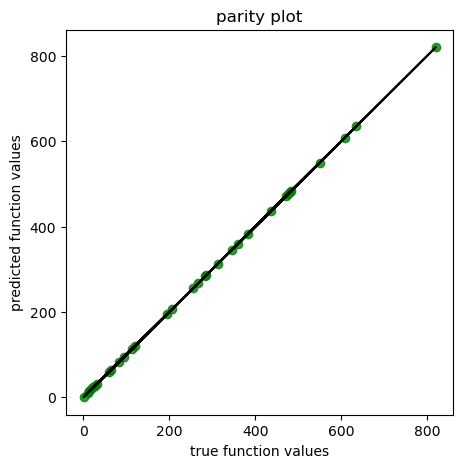

In [7]:
# Pyomo code for GLR based on your data features:
# Plotting design of experiments here:
nsamples =  32  
dim = 2

bounds1 = [0,1]
bounds2 = [0.5,3]

samples = lhs_sampling(dim, nsamples, criterion = 'centered')

#rescale your samples
x1 = samples[:,0]*(bounds1[1] - bounds1[0]) + bounds1[0]
x2 = samples[:,1]*(bounds2[1] - bounds2[0]) + bounds2[0]
f = blackbox_function(x1,x2)


## generate new features
X = mat_1(np.vstack((x1,x2)).T)
feature_list = list(range(X.shape[1]))
points_list = list(range(X.shape[0]))
features = ['1', 'x1', 'x1^2', 'x2^2', 'x1^4', 'x1^2*x2', 'x1*x2', 'x2', 'x2^4', 'x1*x2^2', 'x1^2*x2^2', 'x1^3*x2^2']

from pyomo.environ import *
from sklearn.metrics import r2_score
alphas = np.logspace(-5, 1, num=10)
r2scores = np.zeros(len(alphas))
for alpha,k in zip(alphas,range(len(alphas))):
    m = ConcreteModel()
    m.a = Var(feature_list, within=Reals)
    m.obj = Objective(expr = sum((sum(m.a[j]*X[i,j] for j in feature_list)-f[i])**2 for i in points_list)
                            +alpha*sum(abs(m.a[j])for j in feature_list), sense = minimize)

    solver = SolverFactory('baron')
    solver.solve(m)
    f_pred = [(sum(X[i,j]*value(m.a[j]) for j in feature_list)) for i in points_list]
    coeffs = [np.round(value(m.a[j]),2) for j in feature_list]
    r2scores[k] = r2_score(f,f_pred)
    print('~~~~~~~~~~~~~~~~~~~~~~~~'), print('for alpha : '+str(alpha)+', r2 score :'+str(r2scores[k]))
    print('predicted F:', [str(q1)+str(q2) for q1,q2 in zip(coeffs, features)])
    
opt_alpha = alphas[np.argmax(r2scores)]
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('optimum alpha : '+str(opt_alpha)+', corresponding r2 score :'+str(r2scores[np.argmax(r2scores)]))



m = ConcreteModel()
m.a = Var(feature_list, within=Reals)
m.obj = Objective(expr = sum((sum(m.a[j]*X[i,j] for j in feature_list)-f[i])**2 for i in points_list)
                        +opt_alpha*sum(abs(m.a[j])for j in feature_list), sense = minimize)

solver = SolverFactory('baron')
solver.solve(m)
f_pred = [(sum(X[i,j]*value(m.a[j]) for j in feature_list)) for i in points_list]
coeffs = [np.round(value(m.a[j]),2) for j in feature_list]
print('optimum alpha : '+str(opt_alpha)+', r2 score :'+str(r2_score(f,f_pred)))
print('predicted F: ', [str(q1)+str(q2) for q1,q2 in zip(coeffs, features)])

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(f,f_pred,'o', c = 'g', alpha=0.8)
ax.plot(f,f, '-k')
ax.set(xlabel='true function values', ylabel='predicted function values', title='parity plot')
pass

## With IPOPT
Ipopt cannot handle absolute values, sqrts, or power (x,0.5) when it is in the objective function. Ipopt is a local solver and it continuous differentiability, and neither from the above satisfy. So, use the alternative of writing them as two different constraints

IF you are using ipopt, you can use more than 10 terms

~~~~~~~~~~~~~~~~~~~~~~~~
for alpha : 1e-05, r2 score :0.999999999999984
predicted F: ['1.01', '-2.0x1', '1.0x1^2', '100.0x2^2', '100.0x1^4', '-200.0x1^2*x2', '-0.0x1*x2', '0.0x2', '-0.0x2^4', '0.0x1*x2^2', '-0.0x1^2*x2^2', '0.0x1^3*x2^2']
~~~~~~~~~~~~~~~~~~~~~~~~
for alpha : 4.641588833612782e-05, r2 score :0.9999999999966317
predicted F: ['0.991', '-1.93x1', '0.93x1^2', '100.0x2^2', '100.01x1^4', '-199.95x1^2*x2', '-0.06x1*x2', '0.01x2', '-0.0x2^4', '0.01x1*x2^2', '-0.01x1^2*x2^2', '-0.0x1^3*x2^2']
~~~~~~~~~~~~~~~~~~~~~~~~
for alpha : 0.00021544346900318823, r2 score :0.9999999999797874
predicted F: ['0.971', '-1.84x1', '0.82x1^2', '99.99x2^2', '100.05x1^4', '-199.89x1^2*x2', '-0.13x1*x2', '0.03x2', '0.0x2^4', '0.02x1*x2^2', '-0.01x1^2*x2^2', '-0.01x1^3*x2^2']
~~~~~~~~~~~~~~~~~~~~~~~~
for alpha : 0.001, r2 score :0.9999999996563999
predicted F: ['0.881', '-1.34x1', '0.25x1^2', '99.98x2^2', '100.19x1^4', '-199.55x1^2*x2', '-0.51x1*x2', '0.11x2', '-0.0x2^4', '0.09x1*x2^2', '-0.02x1^2*x2

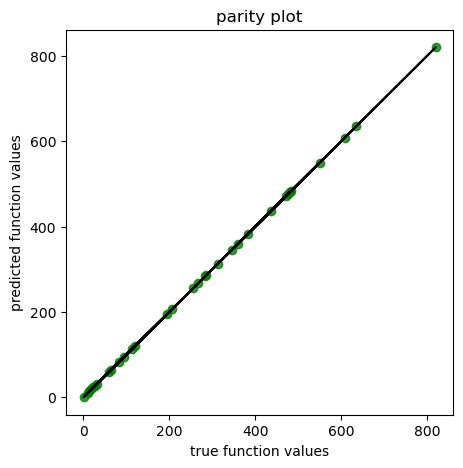

In [8]:
# Pyomo code for GLR based on your data features:

from pyomo.environ import *
from sklearn.metrics import r2_score
alphas = np.logspace(-5, 1, num=10)
r2scores = np.zeros(len(alphas))
for alpha,k in zip(alphas,range(len(alphas))):
    m = ConcreteModel()
    m.a = Var(feature_list, within=Reals)
    m.zp = Var(feature_list, within=NonNegativeReals)
    m.zn = Var(feature_list, within=NonNegativeReals)
    # define constraints
    def con_rule(m, j):
        return m.a[j] == m.zp[j] - m.zn[j]
    m.con = Constraint(feature_list, rule=con_rule)
    m.obj = Objective(expr = sum((sum(m.a[j]*X[i,j] for j in feature_list)-f[i])**2 for i in points_list)
                            +alpha*sum((m.zp[j] + m.zn[j])for j in feature_list), sense = minimize)

    solver = SolverFactory('ipopt')
    solver.solve(m)
    f_pred = [(sum(X[i,j]*value(m.a[j]) for j in feature_list)) for i in points_list]
    coeffs = [np.round(value(m.a[j]),2) for j in feature_list]
    r2scores[k] = r2_score(f,f_pred)
    print('~~~~~~~~~~~~~~~~~~~~~~~~'), print('for alpha : '+str(alpha)+', r2 score :'+str(r2scores[k]))
    print('predicted F:', [str(q1)+str(q2) for q1,q2 in zip(coeffs, features)])
    
opt_alpha = alphas[np.argmax(r2scores)]
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('optimum alpha : '+str(opt_alpha)+', corresponding r2 score :'+str(r2scores[np.argmax(r2scores)]))

m = ConcreteModel()
m.a = Var(feature_list, within=Reals)
m.zp = Var(feature_list, within=NonNegativeReals)
m.zn = Var(feature_list, within=NonNegativeReals)
# define constraints
def con_rule(m, j):
    return m.a[j] == m.zp[j] - m.zn[j]
m.con = Constraint(feature_list, rule=con_rule)
m.obj = Objective(expr = sum((sum(m.a[j]*X[i,j] for j in feature_list)-f[i])**2 for i in points_list)
                        +opt_alpha*sum((m.zp[j] + m.zn[j])for j in feature_list), sense = minimize)

solver = SolverFactory('ipopt')
solver.solve(m)
f_pred = [(sum(X[i,j]*value(m.a[j]) for j in feature_list)) for i in points_list]
coeffs = [np.round(value(m.a[j]),2) for j in feature_list]
print('optimum alpha : '+str(opt_alpha)+', r2 score :'+str(r2_score(f,f_pred)))
print('predicted F:', [str(q1)+str(q2) for q1,q2 in zip(coeffs, features)])

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(f,f_pred,'o', c = 'g', alpha=0.8)
ax.plot(f,f, '-k')
ax.set(xlabel='true function values', ylabel='predicted function values', title='parity plot')
pass

## Problem 3
Solve the same problem as above but using a Mixed-Integer Nonlinear formulation. Use binary variables to select terms. Use an objective function of your choice. Report: 

(A) the objective function you used and value, 
(B) optimized parameters and 
(C) whether some terms were removed and if the correct model was found. 
(D) Which formulation performed best, list at least 1 advantage and 1 disadvantage for each of the methods.

Answer (A): $\color{royalblue}{\text{Objective function:}}$

$$
\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right)^{2} 
$$
where $\hat{y}_{i}=$ predicted value of $y$ at $i^{\text {th }}$ data point

$y_{i}=$ true value at $i^{\text {th }}$ data point
$$
\hat{y}_{i}=\sum_{j=1}^{k} b_{j} * \text { feature }_{j} * a_{j}
$$
$a_{j}=$ coefficient associated with $j^{\text {th }}$ feature

$b_{j}=$ binary variable associated with $j^{\text {th }}$ feature

constraint: 
$$
\sum_{j=1}^{k} b_{j} <= nterms
$$

nterms = number of allowable terms in the formulation

Answer (B): $\color{royalblue}{\text{see the output below}}$ 

Answer (C): $\color{royalblue}{\text{yes, see the output below}}$ 

Answer (D): $\color{royalblue}{\text{both the approaches perform equally good. }}$ 

$\color{royalblue}{\text{Problem 1 is easier to solve but it needs hyperparameter tuning. }}$ 

$\color{royalblue}{\text{Problem 2 is harder to solve, given that it is MINLP formulation}}$ 

## using baron
    baron is an MINLP solver, so it can solve this formulation without any issue. But you would need an academic license because the problem exceeds the demo license limits

In [11]:
# Pyomo code using a Mixed-Integer Formulation for selecting terms:

X = mat_1(np.vstack((x1,x2)).T)
from pyomo.environ import *
from sklearn.metrics import r2_score

terms = np.arange(6,len(feature_list)+1)
r2scores = np.zeros(len(terms))
for term,k in zip(terms,range(len(terms))):
    m = ConcreteModel()
    m.a = Var(feature_list, within=Reals)
    m.b = Var(feature_list, within=Binary)
    m.obj = Objective(expr = sum((sum(m.a[j]*m.b[j]*X[i,j] for j in feature_list)-f[i])**2 for i in points_list), sense = minimize)
    m.cons = Constraint(expr = sum(m.b[j] for j in feature_list) == term)
    solver = SolverFactory('baron')
    solver.solve(m)
    f_pred = [(sum(X[i,j]*value(m.a[j])*value(m.b[j])  for j in feature_list)) for i in points_list]
    coeffs = [np.round(value(m.a[j])*value(m.b[j]) ,2) for j in feature_list]
    r2scores[k] = r2_score(f,f_pred)
    print('~~~~~~~~~~~~~~~~~~~~~~~~')
    print('for nterms : '+str(term)+', best possible r2 score :'+str(r2scores[k]))
    print('predicted binaries : ', [np.round(value(m.b[j]) ,2) for j in feature_list])
    print('predicted function :: ', [str(q1)+str(q2) for q1,q2 in zip(coeffs, features)])

opt_terms = terms[np.argmax(r2scores)]
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('optimum terms : '+str(opt_terms)+', corresponding r2 score :'+str(r2scores[np.argmax(r2scores)]))



~~~~~~~~~~~~~~~~~~~~~~~~
for nterms : 6, best possible r2 score :1.0
predicted binaries :  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
predicted function ::  ['1.01', '-2.0x1', '1.0x1^2', '100.0x2^2', '100.0x1^4', '-200.0x1^2*x2', '0.0x1*x2', '0.0x2', '0.0x2^4', '0.0x1*x2^2', '0.0x1^2*x2^2', '0.0x1^3*x2^2']
~~~~~~~~~~~~~~~~~~~~~~~~
for nterms : 7, best possible r2 score :1.0
predicted binaries :  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
predicted function ::  ['1.01', '-2.0x1', '1.0x1^2', '100.0x2^2', '100.0x1^4', '-200.0x1^2*x2', '0.0x1*x2', '0.0x2', '0.0x2^4', '0.0x1*x2^2', '0.0x1^2*x2^2', '0.0x1^3*x2^2']
~~~~~~~~~~~~~~~~~~~~~~~~
for nterms : 8, best possible r2 score :1.0
predicted binaries :  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
predicted function ::  ['1.01', '-2.0x1', '1.0x1^2', '100.0x2^2', '100.0x1^4', '-200.0x1^2*x2', '0.0x1*x2', '0.0x2', '-0.0x2^4', '0.0x1*x2^2', '0.0x1^2*x2^2', '0.0x1^3*x2^2']
~~~~~~~~~~~~~~~~~~~~~

## using ipopt
    Ipopt is an NLP solver. So even if you formulate an MINLP, using ipopt will give you non binary solutions for any binary variables (same for integer values). This is because ipopt assumes everything to be continuous and will override the variable continuous domain even if you restrict them to binary or integer domain. Essentially you will be solving for a relaxation problem here

    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: Ipopt 3.11.1\x3a Maximum Number of Iterations
        Exceeded.
predicted binaries :  [0.5, 0.5, 0.5, 0.87, 0.84, 0.92, 0.0, 0.0, 0.5, 0.5, 0.0, 0.5]
r2 score :0.9999999999999991
predicted function ::  ['1.01', '-2.0x1', '1.0x1^2', '100.0x2^2', '100.0x1^4', '-200.0x1^2*x2', '-0.0x1*x2', '0.0x2', '0.0x2^4', '0.0x1*x2^2', '-0.0x1^2*x2^2', '0.0x1^3*x2^2']


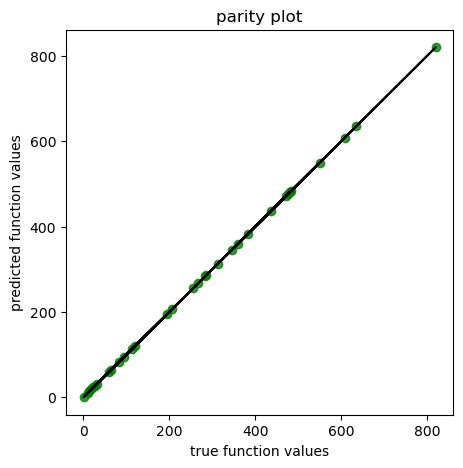

In [12]:
X = mat_1(np.vstack((x1,x2)).T)
from pyomo.environ import *
from sklearn.metrics import r2_score
m = ConcreteModel()
m.a = Var(feature_list, within=Reals)
m.b = Var(feature_list, within=Binary)
m.obj = Objective(expr = sum((sum(m.a[j]*m.b[j]*X[i,j] for j in feature_list)-f[i])**2 for i in points_list), sense = minimize)

solver = SolverFactory('ipopt')
solver.solve(m)
f_pred = [(sum(X[i,j]*value(m.a[j])*value(m.b[j])  for j in feature_list)) for i in points_list]
coeffs = [np.round(value(m.a[j])*value(m.b[j]) ,2) for j in feature_list]
r2scores[k] = r2_score(f,f_pred)
print('predicted binaries : ', [np.round(value(m.b[j]) ,2) for j in feature_list])
print('r2 score :'+str(r2scores[k]))
print('predicted function :: ', [str(q1)+str(q2) for q1,q2 in zip(coeffs, features)])

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(f,f_pred,'o', c = 'g', alpha=0.8)
ax.plot(f,f, '-k')
ax.set(xlabel='true function values', ylabel='predicted function values', title='parity plot')
pass

## Problem 4

Use the provided example code below (make any changes to make it run with your data), to fit a Gaussian Process Regression Model. Perform 5-fold cross validation and discuss: 

(A) Is a good fit or not?

(B) List one advantage and one disadvantage of the Gaussian Process Regression Model compared to the Generalized Linear Regression model. 

Answer (A): 

Answer (B): 

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split, KFold

# create GPR model, with RBF kernel
gp = GPR(kernel=RBF(0.1, (1e-2, 1e2)))

cv_e = {}
cv_data = {}
kf = KFold(n_splits=5, shuffle=False)

x_scaled = samples
y_scaled = (f-min(f))/(max(f)-min(f))
x = np.vstack((x1,x2)).T
# cross validation 
i = 0
for train_index, test_index in kf.split(x_scaled):
    
   # split training and testing set
    x_train, x_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]

    # fit GPR model
    gpmodel = gp.fit(x_train, y_train)

    # predict
    y_pred = np.array(gpmodel.predict(x_test))

    # calculate error
    err = sum((y_pred - y_test)**2)

    # record data and error
    cv_e[i] = err
    cv_data[i] = {'x': x_train,'y': y_train}

    i += 1

# pick the best model
best_cv = min(cv_e, key=cv_e.get)
best_data = cv_data[best_cv]
best_gp = gp.fit(best_data['x'],best_data['y'])

# calculate the average CV error
print(f"average CV error: {sum(cv_e[i] for i in range(len(cv_e)))/len(cv_e):.4f}")

average CV error: 0.0000


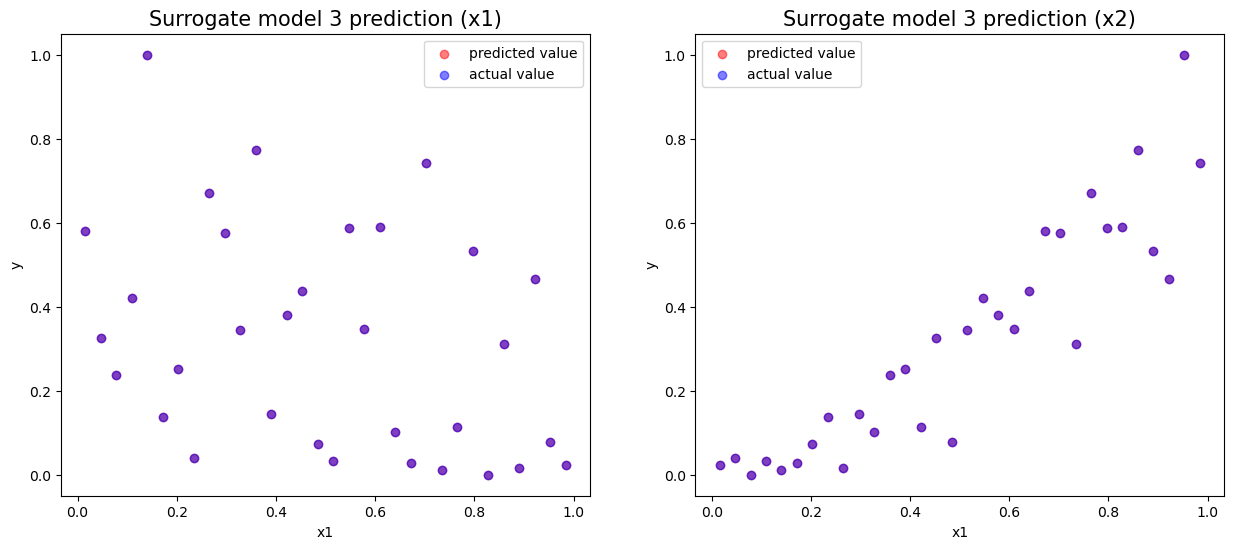

r2 score of the fit :  0.9999999975909897


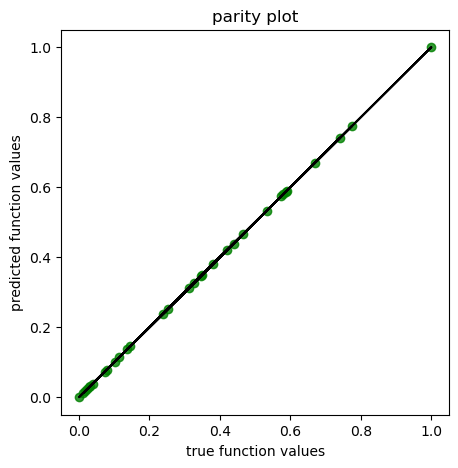

In [14]:
# visualize prediction
fig, ax = plt.subplots(1, 2, figsize=(15,6))

y_gp = best_gp.predict(samples)

ax[0].scatter(x_scaled[:,0], y_gp, color='red', alpha=0.5, label='predicted value')
ax[0].scatter(x_scaled[:,0], y_scaled, color='blue', alpha=0.5, label='actual value')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('y')
ax[0].set_title('Surrogate model 3 prediction (x1)', fontsize=15)
ax[0].legend()

ax[1].scatter(x_scaled[:,1], y_gp, color='red', alpha=0.5, label='predicted value')
ax[1].scatter(x_scaled[:,1], y_scaled, color='blue', alpha=0.5, label='actual value')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('y')
ax[1].set_title('Surrogate model 3 prediction (x2)', fontsize=15)
ax[1].legend()

plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(y_scaled,y_gp,'o', c = 'g', alpha=0.8)
ax.plot(y_scaled,y_scaled, '-k')
ax.set(xlabel='true function values', ylabel='predicted function values', title='parity plot')
pass
print('r2 score of the fit : ', r2_score(y_scaled,y_gp))